In [ ]:
import numpy as np
import pandas as pd
# from shapely.geometry import Point, shape, LineString, mapping, MultiPoint
import geopandas as gpd

import mapclassify
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

import time
import random
import matplotlib.pyplot as plt
from shapely import wkt
import scipy 
from scipy import stats 
from libpysal.weights import Queen, KNN

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import pysal
from pysal.explore import esda
from pysal.lib import weights
from esda.moran import Moran, Moran_BV, Moran_Local, Moran_Local_BV
from splot.esda import plot_local_autocorrelation
from splot.esda import plot_moran_bv_simulation, plot_moran_bv
from splot.esda import moran_scatterplot

import pygeoda



: 

In [2]:
gdfjoined  = gpd.read_file( r"exported_data/states_sheldus_all.shp")
#gdfjoined = gpd.read_file( r"exported_data/states_sheldus_declared.shp")

gdfjoined2 = gdfjoined.to_crs({'init':'epsg:2163'})
#usstates = usstates.to_crs(4326)

gdfjoined2.crs

/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [3]:
gdfjoined2.head()

,STATE,STATEABBRV,COUNTY,COUNTYFIPS,STCOFIPS,POPULATION,BUILDVALUE,AGRIVALUE,SOVI_SCORE,RESL_VALUE,...,HAtotal,HAcount,PAcount,SBAcount,SBAProjcou,SBAapprove,HazardCoun,x,y,geometry
0,Alabama,AL,Autauga,001,01001,58764,9.123274e+09,24613998.0,51.299999,2.604995,...,7.687544e+06,4.0,0.0,44.0,6.0,1.160600e+06,56.0,-86.642759,32.534932,"POLYGON ((-86.41284 32.63589, -86.41279 32.625..."
1,Alabama,AL,Baldwin,003,01003,231365,4.596848e+10,138089013.0,31.030001,2.745075,...,9.947442e+08,34.0,0.0,1634.0,35.0,1.577607e+09,146.0,-87.723352,30.736470,"MULTIPOLYGON (((-87.92666 30.66002, -87.92688 ..."
2,Alabama,AL,Barbour,005,01005,25160,4.847697e+09,121075758.0,99.269997,2.383568,...,2.175617e+05,2.0,0.0,19.0,2.0,1.048000e+05,40.0,-85.393206,31.869615,"POLYGON ((-85.25954 32.13837, -85.25882 32.138..."
3,Alabama,AL,Bibb,007,01007,22239,3.146947e+09,4819356.0,80.779999,2.471525,...,2.454976e+07,4.0,0.0,55.0,4.0,4.280200e+06,41.0,-87.126450,32.998655,"POLYGON ((-87.02581 33.21717, -87.02573 33.209..."
4,Alabama,AL,Blount,009,01009,58992,7.815620e+09,278570859.0,51.369999,2.488382,...,5.337763e+07,4.0,0.0,65.0,7.0,1.391430e+07,70.0,-86.567381,33.980880,"POLYGON ((-86.44414 34.25913, -86.44434 34.256..."


In [4]:
print( gdfjoined2.columns )

Index(['STATE', 'STATEABBRV', 'COUNTY', 'COUNTYFIPS', 'STCOFIPS', 'POPULATION',
       'BUILDVALUE', 'AGRIVALUE', 'SOVI_SCORE', 'RESL_VALUE', 'fips', 'index',
       'HMAprojAmo', 'AdminCostA', 'NumfinalPr', 'CropDmg', 'CropDmg(AD',
       'CropDmgPer', 'PropertyDm', 'Property_1', 'Property_2', 'Injuries',
       'InjuriesPe', 'Fatalities', 'Fataliti_1', 'Duration_D', 'PAprojectA',
       'PDMprojAmo', 'PDMcount', 'PDMNumfina', 'HMAcount', 'HAtotal',
       'HAcount', 'PAcount', 'SBAcount', 'SBAProjcou', 'SBAapprove',
       'HazardCoun', 'x', 'y', 'geometry'],
      dtype='object')


In [90]:
#gdfjoined2['SBATotal'] = gdfjoined2['ApprovLo_1'] + gdfjoined2['ApprovLoan']
#gdfjoined2['HATotal'] = gdfjoined2['HAOAproved'] + gdfjoined2['HARAproved'] 
gdfjoined2['totalAssist'] = gdfjoined2['HMAprojAmo'] + gdfjoined2['PAprojectA'] + gdfjoined2['PDMprojAmo'] + gdfjoined2['HAtotal'] + gdfjoined2['SBAapprove'] 
gdfjoined2['totalAssist3'] = gdfjoined2['HMAprojAmo'] + gdfjoined2['PAprojectA'] + gdfjoined2['PDMprojAmo'] + gdfjoined2['HAtotal']

gdfjoined2['totalDamage'] = gdfjoined2['CropDmg'] + gdfjoined2['PropertyDm'] 
gdfjoined2['DamageSOVI'] = gdfjoined2['HazardCoun'] * gdfjoined2['SOVI_SCORE'] 


In [13]:
print( gdfjoined2.total_bounds )
xmin, ymin, xmax, ymax = [-125.78, 22.25, -65.62, 50.48]

[-124.7541084    24.52108866  -66.95000492   49.38435908]


In [14]:
#print( xmin, ymin, xmax, ymax )
#gdfjoined2 = gdfjoined2.cx[xmin:xmax, ymin:ymax]

In [27]:
y = gdfjoined2['totalAssist'].values
w = Queen.from_dataframe(gdfjoined2)
w.transform = 'r'

w = Queen.from_dataframe( gdfjoined2 )
moran_loc = Moran_Local(y, w)
#moran_loc.I

/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
 There are 4 islands with ids: 1186, 1192, 1836, 2946.
  warnings.warn(message)


('WARNING: ', 1186, ' is an island (no neighbors)')
('WARNING: ', 1192, ' is an island (no neighbors)')
('WARNING: ', 1836, ' is an island (no neighbors)')
('WARNING: ', 2946, ' is an island (no neighbors)')
('WARNING: ', 1186, ' is an island (no neighbors)')
('WARNING: ', 1192, ' is an island (no neighbors)')
('WARNING: ', 1836, ' is an island (no neighbors)')
('WARNING: ', 2946, ' is an island (no neighbors)')


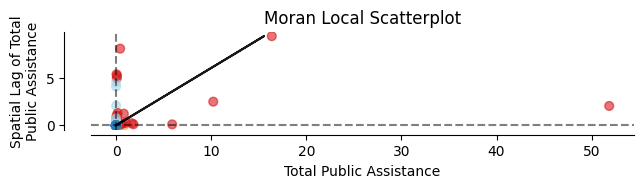

In [29]:
from splot.esda import plot_moran

fig, ax = moran_scatterplot(moran_loc, p=0.05)
ax.set_xlabel('Total Public Assistance')
ax.set_ylabel('Spatial Lag of Total\nPublic Assistance')
plt.show()


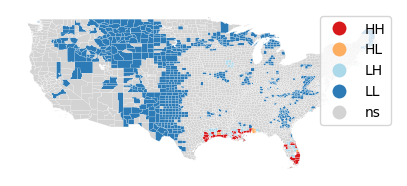

In [112]:
from splot.esda import lisa_cluster
lisa_cluster(moran_loc, gdfjoined2, p=0.05, figsize = (5,5))
plt.show()


In [80]:
#gdfjoined2['totalDamage2'] = ( gdfjoined2['totalDamage'] - gdfjoined2['totalDamage'].mean()) / gdfjoined2['totalDamage'].std() 
#gdfjoined2['totalAssist2'] = ( gdfjoined2['totalAssist'] - gdfjoined2['totalAssist'].mean()) / gdfjoined2['totalAssist'].std() 
#gdfjoined2['DamageSOVI2']  = ( gdfjoined2['DamageSOVI']  - gdfjoined2['DamageSOVI'].mean()) / gdfjoined2['DamageSOVI'].std() 


gdfjoined2['totalDamage2']  = scipy.stats.zscore( gdfjoined2['totalDamage'] )
gdfjoined2['totalAssist2']  = scipy.stats.zscore( gdfjoined2['totalAssist'] )
gdfjoined2['DamageSOVI2']   = scipy.stats.zscore( gdfjoined2['DamageSOVI'] )



In [110]:
y1 = gdfjoined2[ 'totalAssist' ].values
w1 = Queen.from_dataframe( gdfjoined2 )
w1.transform = 'r'
x1 = (gdfjoined2['totalDamage'] ).values
moran_loc_bv1 = Moran_Local_BV(x1, y1, w1)

#plot_local_autocorrelation(moran_loc_bv1, gdfjoined2, 'HMAprojAmo')
#plt.show()
print( len( moran_loc_bv1.q ) )
print(  moran_loc_bv1.p_sim )
print( moran_loc_bv1.permutations )
gdfjoined2['LossI'] = moran_loc_bv1.q

gdfjoined2['x'] = moran_loc_bv1.p_sim
gdfjoined2['Lossp2'] = moran_loc_bv1.p_sim

gdfjoined2.loc[ gdfjoined2['x'] < 0.05  ,'LossI'] = 1
gdfjoined2.loc[ gdfjoined2['x'] >= 0.05 ,'Lossp2'] = 0

#gdfjoined2['LossI'] = gdfjoined2['LossI'] * gdfjoined2[ 'Lossp2' ]
#plt.hist(  moran_loc_bv1.p_sim )

('WARNING: ', 1186, ' is an island (no neighbors)')
('WARNING: ', 1192, ' is an island (no neighbors)')
('WARNING: ', 1836, ' is an island (no neighbors)')
('WARNING: ', 2946, ' is an island (no neighbors)')
3108
[0.451 0.035 0.059 ... 0.005 0.013 0.042]
999


/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
 There are 4 islands with ids: 1186, 1192, 1836, 2946.
  warnings.warn(message)


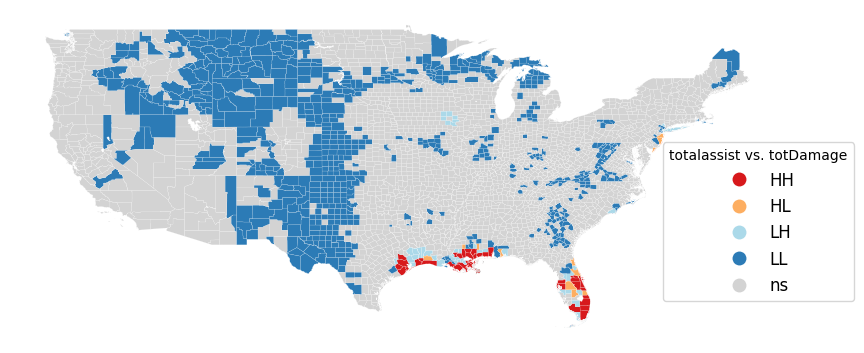

In [111]:
lisa_cluster(moran_loc_bv1, gdfjoined2, p=0.05, 
             legend_kwds={'loc': 'lower right',  'title': "totalassist vs. totDamage", 
                                                                'bbox_to_anchor': (1.1, 0.1),
                                                                'fontsize':'large' },
                                                                 figsize=(10, 12), )
plt.show()


In [99]:
gdfjoined2.columns

Index(['STATE', 'STATEABBRV', 'COUNTY', 'COUNTYFIPS', 'STCOFIPS', 'POPULATION',
       'BUILDVALUE', 'AGRIVALUE', 'SOVI_SCORE', 'RESL_VALUE', 'fips', 'index',
       'HMAprojAmo', 'AdminCostA', 'NumfinalPr', 'CropDmg', 'CropDmg(AD',
       'CropDmgPer', 'PropertyDm', 'Property_1', 'Property_2', 'Injuries',
       'InjuriesPe', 'Fatalities', 'Fataliti_1', 'Duration_D', 'PAprojectA',
       'PDMprojAmo', 'PDMcount', 'PDMNumfina', 'HMAcount', 'HAtotal',
       'HAcount', 'PAcount', 'SBAcount', 'SBAProjcou', 'SBAapprove',
       'HazardCoun', 'x', 'y', 'geometry', 'totalAssist', 'totalDamage',
       'DamageSOVI', 'LossI', 'Lossp2', 'DSVILossI', 'DSVILossp2', 'TotASVI',
       'TotAp2', 'totalDamage2', 'totalAssist2', 'DamageSOVI2',
       'totalAssist3'],
      dtype='object')

In [101]:
y5 = ( gdfjoined2['totalAssist3'] ).values
#w5 = Queen.from_dataframe( gdfjoined2 )

#w5.transform = 'r'
x5 = gdfjoined2['DamageSOVI'].values 
moran_loc_bv5 = Moran_Local_BV(x5, y5, w1)

gdfjoined2['DSVILossI'] = moran_loc_bv5.q

gdfjoined2['x'] = moran_loc_bv5.p_sim
gdfjoined2['DSVILossp2'] = moran_loc_bv5.p_sim

gdfjoined2.loc[ gdfjoined2['x'] < 0.05  ,'DSVILossp2'] = 1
gdfjoined2.loc[ gdfjoined2['x'] >= 0.05 ,'DSVILossp2'] = 0

gdfjoined2['DSVILossI'] = gdfjoined2['DSVILossI'] * gdfjoined2[ 'DSVILossp2' ]


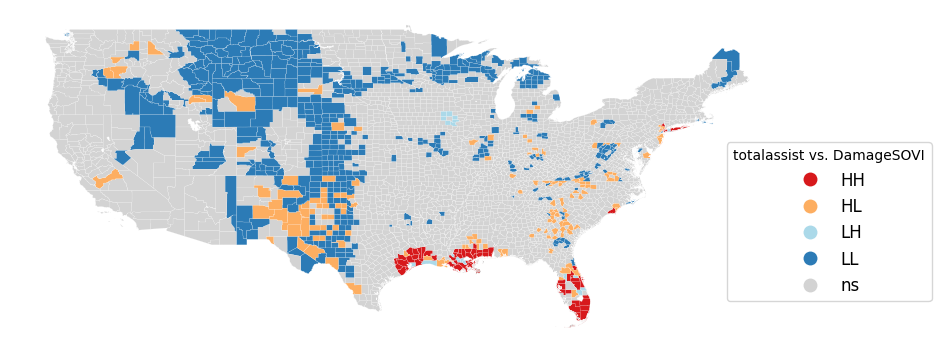

In [102]:
lisa_cluster(moran_loc_bv5, gdfjoined2, p=0.05, 
             legend_kwds={'loc': 'lower right',  'title': "totalassist vs. DamageSOVI", 
                                                                'bbox_to_anchor': (1.2, 0.1),
                                                                'fontsize':'large' },
                                                                 figsize=(10, 12), )
plt.show()


In [103]:
gdfjoined2 = gpd.GeoDataFrame( gdfjoined2, geometry = 'geometry', crs="EPSG:4326")
gdfjoined2.to_file(r"/Users/yuhan/Desktop/paper——revision/export_results/df_localMoran_all.shp")

/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_29833/625493599.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfjoined2.to_file(r"/Users/yuhan/Desktop/paper——revision/export_results/df_localMoran_all.shp")


In [104]:
gdfjoined3 = gpd.read_file( r"exported_data/states_sheldus_declared.shp")
gdfjoined3 = gdfjoined3.to_crs({'init':'epsg:2163'})

/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [105]:
#gdfjoined2['SBATotal'] = gdfjoined2['ApprovLo_1'] + gdfjoined2['ApprovLoan']
#gdfjoined2['HATotal'] = gdfjoined2['HAOAproved'] + gdfjoined2['HARAproved'] 
gdfjoined3['totalAssist'] = gdfjoined3['HMAprojAmo']  + gdfjoined3['PAprojectA'] + gdfjoined3['PDMprojAmo'] + gdfjoined3['HAtotal'] + gdfjoined3['SBAapprove'] 
gdfjoined3['totalAssis2'] = gdfjoined3['HMAprojAmo']  + gdfjoined3['PAprojectA'] + gdfjoined3['PDMprojAmo'] + gdfjoined3['HAtotal']

gdfjoined3['totalDamage'] = gdfjoined3['CropDmg'] + gdfjoined3['PropertyDm'] 
gdfjoined3['DamageSOVI']  = gdfjoined3['HazardCoun'] * gdfjoined3['SOVI_SCORE'] 

In [106]:
y11 = ( gdfjoined3['totalAssist'] ).values
w11 = Queen.from_dataframe( gdfjoined3 )

w11.transform = 'r'
x11 = gdfjoined3['totalDamage'].values 
moran_loc_bv11 = Moran_Local_BV(x11, y11, w11)

gdfjoined3['TotADamage'] = moran_loc_bv11.q
gdfjoined3['x']          = moran_loc_bv11.p_sim

gdfjoined3['TotADamage_p_sim'] = moran_loc_bv11.p_sim

gdfjoined3.loc[ gdfjoined3['x'] < 0.05  ,'TotADamage_p_sim'] = 1
gdfjoined3.loc[ gdfjoined3['x'] >= 0.05 ,'TotADamage_p_sim'] = 0
gdfjoined3['TotADamage'] = gdfjoined3['TotADamage'] * gdfjoined3[ 'TotADamage_p_sim' ]

('WARNING: ', 1186, ' is an island (no neighbors)')
('WARNING: ', 1192, ' is an island (no neighbors)')
('WARNING: ', 1836, ' is an island (no neighbors)')
('WARNING: ', 2946, ' is an island (no neighbors)')


/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
 There are 4 islands with ids: 1186, 1192, 1836, 2946.
  warnings.warn(message)


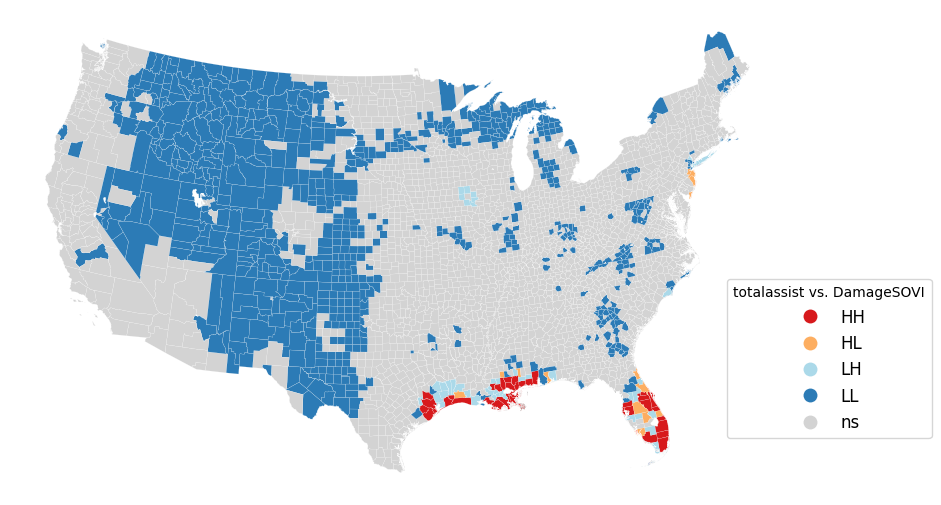

In [107]:
lisa_cluster(moran_loc_bv11, gdfjoined3, p=0.05, 
             legend_kwds={'loc': 'lower right',  'title': "totalassist vs. DamageSOVI", 
                           'bbox_to_anchor': (1.2, 0.1), 'fontsize':'large' }, figsize=(10, 12), )
plt.show()

In [108]:
y12 = ( gdfjoined3['totalAssist'] ).values
w12 = Queen.from_dataframe( gdfjoined3 )

w12.transform = 'r'
x12 = gdfjoined3['DamageSOVI'].values 
moran_loc_bv12 = Moran_Local_BV( x12, y12, w12)

gdfjoined3['TotASVI'] = moran_loc_bv12.q
gdfjoined3['x'] = moran_loc_bv12.x
gdfjoined3['TotAp2'] = moran_loc_bv12.p_sim

gdfjoined3.loc[ gdfjoined3['x'] < 0.05  ,'TotAp2'] = 1
gdfjoined3.loc[ gdfjoined3['x'] >= 0.05 ,'TotAp2'] = 0
gdfjoined3['TotASVI'] = gdfjoined3['TotASVI'] * gdfjoined3[ 'TotAp2' ]

('WARNING: ', 1186, ' is an island (no neighbors)')
('WARNING: ', 1192, ' is an island (no neighbors)')
('WARNING: ', 1836, ' is an island (no neighbors)')
('WARNING: ', 2946, ' is an island (no neighbors)')


/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
 There are 4 islands with ids: 1186, 1192, 1836, 2946.
  warnings.warn(message)


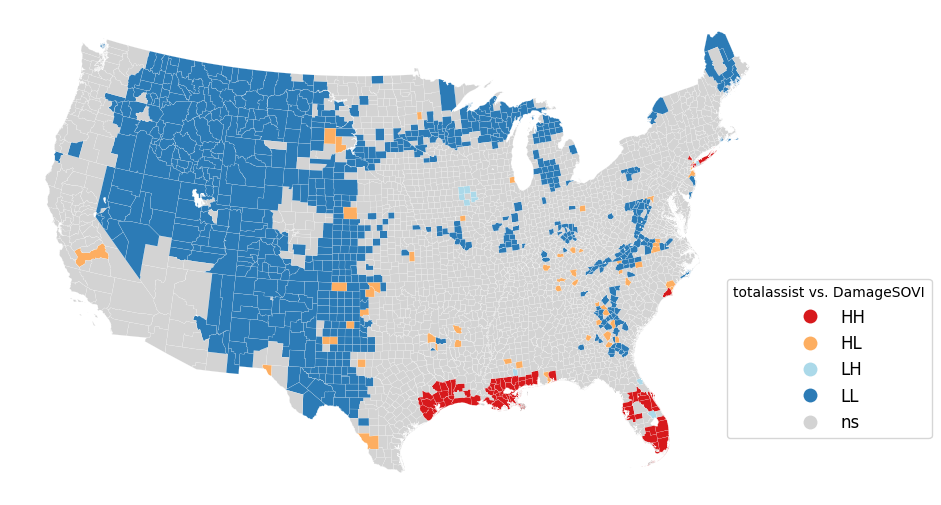

In [109]:
lisa_cluster(moran_loc_bv12, gdfjoined3, p=0.05, 
             legend_kwds={'loc': 'lower right',  'title': "totalassist vs. DamageSOVI", 
                           'bbox_to_anchor': (1.2, 0.1), 'fontsize':'large' }, figsize=(10, 12), )
plt.show()

In [ ]:
gdfjoined3 = gpd.GeoDataFrame( gdfjoined3, geometry = 'geometry', crs="EPSG:4326")
gdfjoined3.to_file(r"/Users/yuhan/Desktop/paper——revision/export_results/df_localMoran_declared.shp")


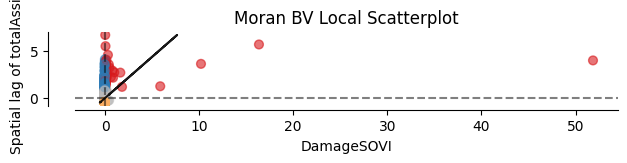

In [54]:
fig, ax = moran_scatterplot(moran_loc_bv12, p=0.05)
ax.set_xlabel('DamageSOVI')
ax.set_ylabel('Spatial lag of totalAssist')
plt.show()

In [67]:
moran_loc_bv12.p_sim


array([0.133, 0.001, 0.325, ..., 0.003, 0.003, 0.006])

In [69]:
np.unique( moran_loc_bv12.q )

array([1, 2, 3, 4])